In [196]:
# 주제 : 신규 상장 이후 300일간의 거래일 분석

# 상장 이후 300일간의 거래일을 분석하여 신규 상장 주식의 초반 흐름을 살펴보고자 합니다.

# 최근 들어 신규 상장 불패 신화 관련, 뉴스가 많이 들려오고 있습니다. 또한, 한때 공모주 열풍이 불기도 하였습니다.
# 그렇다면, 진짜로 공모주는 불패 신화일까? 또한 상장일 이후 언제쯤 판매하는 것이 최고의 이득을 볼 수 있는지 분석하는 최종 프로젝트를 하고자 합니다.
# 새로운 주식 데이터를 api입수는 하지 않았지만, 원래 이 데이터에 대해 관심 있어 공공데이터 포털 : 금융위원회_주식시세정보  및 KIND : 신규 상장 기업 정보를 이용하고자 합니다.

In [3]:
# 공공 데이터 포털 요청 관련
import requests
import xml.etree.ElementTree as et
import bs4
from lxml import html
from urllib.parse import urlencode, quote_plus, unquote

# 시각화
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from matplotlib import rcParams
from matplotlib import font_manager, rc
import matplotlib.dates as mdates
import seaborn as sns

# 기본 module
import pandas as pd
import numpy as np
import pprint
from os import name
from tqdm import tqdm

###한글 폰트###
rcParams['axes.unicode_minus'] = False
#plt.rcParams['font.family'] = 'Malgun Gothic'

font_name = font_manager.FontProperties(fname="/Users/gominseong/Library/Fonts/MaruBuri-Regular.otf").get_name()
rc('font', family=font_name)

In [4]:
df = pd.read_csv("KRX_NewStock_2020~2021.csv")
newstock20_21 = list(df["srtnCd"].unique())

df.columns

Index(['basDt', 'srtnCd', 'isinCd', 'itmsNm', 'mrktCtg', 'clpr', 'vs', 'fltRt',
       'mkp', 'hipr', 'lopr', 'trqu', 'trPrc', 'lstgStCnt', 'mrktTotAmt'],
      dtype='object')

#### newstock20_21 : 2020년~2021년 KRX신규상장 종목번호 리스트
#### df : 위에 해당하는 기업의 주가 정보 데이터 프레임
|| df columns 설명 || 
- basDt 기준일자
- srtnCd 종목코드
- isinCd 국제채권번호
- itmsNm 종목명
- mrktCtg 상장시장
- clpr 종가
- vs 전일 대비 등락
- fltRt 전일 대비 등락률
- mkp 시가
- hipr 고가
- lowpr 저가
- trqu 거래량
- trPrc 거래 금액
- lstgStCnt 상장 주식 수
- mrktTotAmt 시총

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105410 entries, 0 to 105409
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   basDt       105410 non-null  int64  
 1   srtnCd      105410 non-null  int64  
 2   isinCd      105410 non-null  object 
 3   itmsNm      105410 non-null  object 
 4   mrktCtg     105410 non-null  object 
 5   clpr        105410 non-null  int64  
 6   vs          105410 non-null  int64  
 7   fltRt       105410 non-null  float64
 8   mkp         105410 non-null  int64  
 9   hipr        105410 non-null  int64  
 10  lopr        105410 non-null  int64  
 11  trqu        105410 non-null  int64  
 12  trPrc       105410 non-null  int64  
 13  lstgStCnt   105410 non-null  int64  
 14  mrktTotAmt  105410 non-null  int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 12.1+ MB


In [6]:
df.head()

,basDt,srtnCd,isinCd,itmsNm,mrktCtg,clpr,vs,fltRt,mkp,hipr,lopr,trqu,trPrc,lstgStCnt,mrktTotAmt
0,20230327,400560,KR7400560009,하나금융20호스팩,KOSDAQ,2280,0,0.0,0,0,0,0,0,3050000,6954000000
1,20230324,400560,KR7400560009,하나금융20호스팩,KOSDAQ,2280,0,0.0,0,0,0,0,0,3050000,6954000000
2,20230323,400560,KR7400560009,하나금융20호스팩,KOSDAQ,2280,0,0.0,0,0,0,0,0,3050000,6954000000
3,20230322,400560,KR7400560009,하나금융20호스팩,KOSDAQ,2280,0,0.0,0,0,0,0,0,3050000,6954000000
4,20230321,400560,KR7400560009,하나금융20호스팩,KOSDAQ,2280,0,0.0,0,0,0,0,0,3050000,6954000000


In [7]:
trading_day = sorted(list(df["basDt"].unique()))

In [8]:
df['basDt'] = df['basDt'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [10]:
# 2020년부터 krx에 상장한 기업의 수
df["itmsNm"].nunique()

224

In [19]:
df['itmsNm'] = df['itmsNm'].apply(lambda x: str(x))

In [35]:
# 2020년부터 krx에 상장한 기업의 수, 스팩은 제외하고 분석 진행
spac_index = df.query("itmsNm.str.contains('스팩')").index
df = df.iloc[list(set(df.index) - set(spac_index))]

In [36]:
# 300거래일 이상이 존재하는 주식 리스트
over300 = df.groupby("itmsNm")["isinCd"].count().reset_index().query("isinCd >= 300")["itmsNm"].unique()

In [43]:
# 주식 별 300거래일 dataframe을 생성
df_lst = []
for name in tqdm(over300):
    df_lst.append(df.query("itmsNm == @name").sort_values(by="basDt").iloc[:300])

100%|████████████████████████████████████████| 161/161 [00:00<00:00, 471.03it/s]


In [47]:
df_lst[0].tail()

,basDt,srtnCd,isinCd,itmsNm,mrktCtg,clpr,vs,fltRt,mkp,hipr,lopr,trqu,trPrc,lstgStCnt,mrktTotAmt
90564,2022-09-30,297890,KR7297890006,HB솔루션,KOSDAQ,13350,-350,-2.55,13350,13800,13050,64962,868051850,16720093,223213241550
90563,2022-10-04,297890,KR7297890006,HB솔루션,KOSDAQ,14200,850,6.37,13600,14350,13600,49590,688866550,16720093,237425320600
90562,2022-10-05,297890,KR7297890006,HB솔루션,KOSDAQ,14000,-200,-1.41,14300,14900,13800,76574,1082802300,16720093,234081302000
90561,2022-10-06,297890,KR7297890006,HB솔루션,KOSDAQ,14600,600,4.29,14200,14800,14050,67089,969734600,16720093,244113357800
90560,2022-10-07,297890,KR7297890006,HB솔루션,KOSDAQ,14300,-300,-2.05,14350,14500,14100,52315,743568850,16720093,239097329900


In [51]:
for df in df_lst:
    df["log_fltRt"] = df["fltRt"].apply(lambda x: np.log(x+1))

In [54]:
np.log(2560)-np.log(2900)

-0.12470347850095731

In [63]:
# 종목별 로그 수익률 계산
for df in df_lst:
    lst=[0]
    for i in range(299):
        lst.append(np.log(df.iloc[i+1,5])-np.log(df.iloc[i,5]))
    df["log_fltRt"]=lst

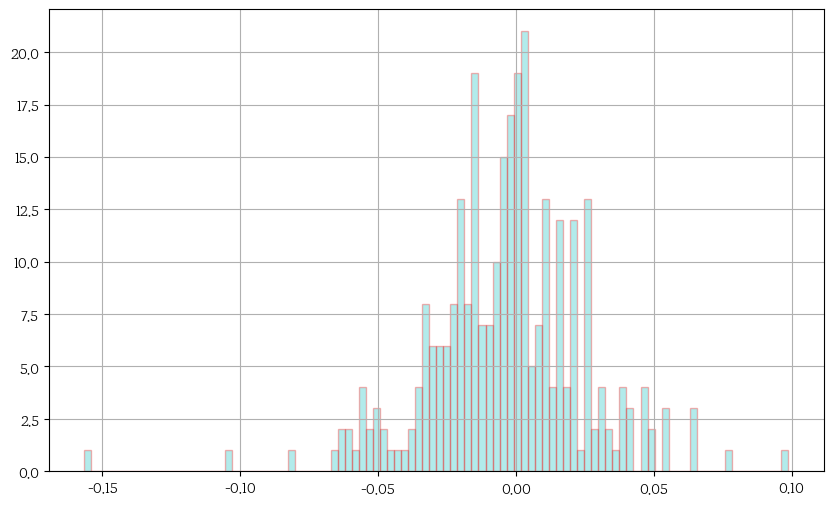

In [68]:
# 특정 종목 로그 수익률 히스토 그램.
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df_lst[-1]["log_fltRt"], alpha=0.3, color = 'c', ec = 'red', bins=100) 
ax.grid(True)
plt.savefig("retrun_histogram01.png", dpi=150, bbox_inches='tight')
plt.show()

In [77]:
print(len(df_lst))
#총 161개의 신규 상장 주식 중 상장 후 300일 거래일이 지나고 나서 주가가 오른 비율 구하기

log_sum={}
for df,name in zip(df_lst, over300):
    log_sum[name] = (np.exp(df["log_fltRt"].sum())-1)*100

161


In [104]:
# 한 개의 신규 상장 주식을 300일간 가지고 있었을 때 오를 확률
plus, minus = 0, 0
for a in log_sum.values():
    if a > 0: plus+=1
    else: minus+=1
print(plus/(plus+minus))

0.14906832298136646


In [105]:
import math
p_rate = plus/(plus+minus)

a = math.factorial(10)
b = math.factorial(7) *math.factorial(3)
c = ((p_rate)**7) * ((1-p_rate) **3)
number = a/b

prob = number * c
print("10개 중 7개가 오를 확률 : ", prob)

10개 중 7개가 오를 확률 :  0.00012093802699810594


In [113]:
var=np.sqrt(p_rate * (1-p_rate)) * np.sqrt(161)

In [114]:
p_rate*161
# 신규 상장 주식 161개 중 24개 주변으로 약 4.5개 전후로 오른다.

24.0

In [118]:
var/161*100
# 신규 상장 주식을 사서 300일간의 거래일 동안 보유했을 때 
# 오를 확률은 약15% 주변으로 약 3% 전후로 오른다.

2.8069009685966235

In [124]:
np.random.choice(over300, size=50)

array(['원티드랩', '비트나인', '맥스트', '아주스틸', '피엔케이피부임상연구센타', '차백신연구소',
       '아이패밀리에스씨', '딥노이드', '플레이디', '한국파마', '피엔케이피부임상연구센타', '와이팜', '핌스',
       '에스디바이오센서', '원방테크', '플래티어', '카카오페이', '솔루엠', '뷰노', '차백신연구소', '서남',
       '나우코스', '레인보우로보틱스', '씨엔티드림', '롯데렌탈', '맥스트', '크래프톤', '리파인', '크래프톤',
       '이노뎁', '이삭엔지니어링', '아스플로', '롯데렌탈', '라이프시맨틱스', '브레인즈컴퍼니', '이루다',
       '큐라클', '아이티아이즈', 'SK바이오팜', '신도기연', '지앤비에스엔지니어링', '에이프로', '나우코스',
       '네패스아크', '마인즈랩', '지오엘리먼트', '제노코', '비비씨', '플래티어', '나우코스'],
      dtype=object)

In [134]:
size = 50 # 투자 기업 수
n = 10000 # 반복실행횟수
result = []
for i in range(n):
    money = 0
    sample = np.random.choice(over300, size=50)
    for s in sample:
        money += log_sum[s]
    result.append(money/50)

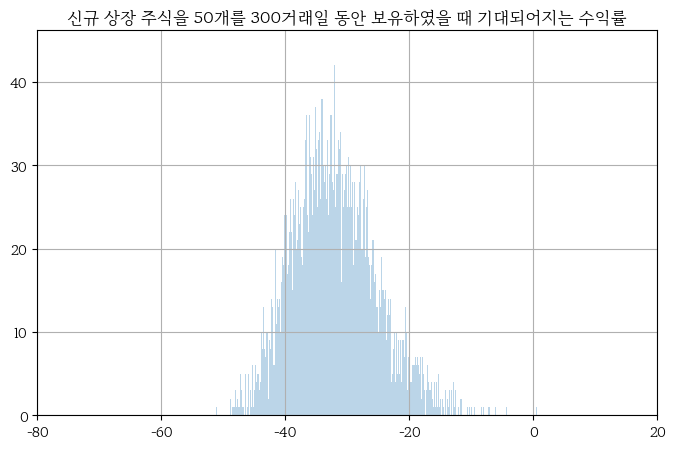

In [138]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(result, alpha=0.3, bins=1000) 
ax.grid(True)
ax.set_xlim((-80, 20))
plt.title("신규 상장 주식을 50개를 300거래일 동안 보유하였을 때 기대되어지는 수익률")
plt.savefig("bootstrapping01.png", dpi=150, bbox_inches='tight')
plt.show()

In [139]:
ret5 = np.percentile(result, 5)

In [140]:
VaR95= ret5*200000000

In [141]:
VaR95

-8497379026.4314375